# PyTorch for Deep Learning Bootcamp - Model Deployment Chapter

## 0. Importing dependencies

In [1]:
!python --version

Python 3.12.3


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from time import time

#now let's import the helper scripts. If not present in the folder, then the scripts will be downloaded from the github repository
try:
    from scripts import dataset_setup
    from scripts import utilities
    from scripts import model_setup
except ImportError:
    print('The helper scripts are not present in the working folder... downloading them from github repository:\n\t'
          'https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/tree/main/05_PyTorch_Food101/scripts')
    !git clone https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke
    !mv ./PyTorch_Course_by_Daniel_Bourke/05_PyTorch_Food101/scripts .
    !rm -rf ./PyTorch_Course_by_Daniel_Bourke 
    from scripts import dataset_setup
    from scripts import utilities
    from scripts import model_setup
    print('Dependencies properly imported...')

## 1. Creating the datasets and dataloaders

### 1.1 Downloading the data and setting up the Datasets folder

In [3]:
#setting up the folder names
MODEL_FOLDER = Path(os.getcwd() + '/saved_models/new_model')
LOG_FOLDER = MODEL_FOLDER
FOOD101_PATH = Path(os.getcwd() + '/Datasets/food-101') #folder where the original dataset is stored in the
DATASET_TRAIN_FOLDER = Path(os.getcwd() + '/Datasets/train')
DATASET_TEST_FOLDER = Path(os.getcwd() + '/Datasets/final_test')

In [4]:
logger = utilities.Logging_Agent(LOG_FOLDER)
logger

Logging Agent pointing to: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/08_Model_Deployment/saved_models/new_model

In [5]:
if not DATASET_TEST_FOLDER.parent.exists():
    os.mkdir(DATASET_TEST_FOLDER.parent)
    print('Dataset folder created...')
    

## 2. Importing the ViT Model (already trained)

## 2.a Re-creating a feature extractor which can import the data of the pretrained model (ViT Model)

In [6]:
vit_model_pretrained = model_setup.ViT_B_16(name='ViT_model_pretrained')

In [7]:
import torchinfo

BATCH_SIZE = 2 ** 5
torchinfo.summary(model=vit_model_pretrained,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViT_B_16                                           [32, 3, 224, 224]         [32, 1000]                --                        True
├─VisionTransformer: 1-1                           [32, 3, 224, 224]         [32, 1000]                768                       True
│    └─Conv2d: 2-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    └─Encoder: 2-2                                [32, 197, 768]            [32, 197, 768]            151,296                   True
│    │    └─Dropout: 3-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    │    └─Sequential: 3-2                        [32, 197, 768]            [32, 197, 768]            85,054,464                True
│    │    └─LayerNorm: 3-3                         [32, 197

In [8]:
for param in vit_model_pretrained.parameters():
    param.requires_grad = False

In [9]:
#before overwriting the head, the pretrained model shows the following final block
vit_model_pretrained.pre_trained_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [10]:
vit_model_pretrained.pre_trained_model.heads = nn.Linear(
    in_features=768,
    out_features=5,
    bias=True
)

vit_model_pretrained.pre_trained_model.heads

Linear(in_features=768, out_features=5, bias=True)

In [11]:
torchinfo.summary(model=vit_model_pretrained,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViT_B_16                                           [32, 3, 224, 224]         [32, 5]                   --                        Partial
├─VisionTransformer: 1-1                           [32, 3, 224, 224]         [32, 5]                   768                       Partial
│    └─Conv2d: 2-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
│    └─Encoder: 2-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    │    └─Dropout: 3-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    │    └─Sequential: 3-2                        [32, 197, 768]            [32, 197, 768]            (85,054,464)              False
│    │    └─LayerNorm: 3-3                        

In [12]:
import pathlib

VIT_FILE = pathlib.Path('/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/07_PyTorch_PaperReplicating/saved_models/ViT-B-16-pretrained/model_checkpoint_epoch_20.pt')
with open(VIT_FILE, 'rb') as f:
    checkpoint = torch.load(f)
    
vit_model_pretrained.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
vit_model_pretrained

ViT_B_16(
  (pre_trained_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (l

## 2.b Re-creating a feature extractor which can import the data of the pretrained model (EffNetB2)

In [14]:
effnet_b2_pretrained = model_setup.EffNetB2(name='EfficientNetB2')

In [15]:
for param in effnet_b2_pretrained.features.parameters():
    param.requires_grad = False

### Resetting the classifier layer

In [16]:
#checking the dimension of the output of the model down to the avgpooling layer, in order to set properly the head of the model when it comes to talk of transfer learning
effnet_b2_pretrained.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [17]:
effnet_b2_pretrained.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=5, bias=True)
)
effnet_b2_pretrained.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1408, out_features=5, bias=True)
)

In [18]:
torchinfo.summary(effnet_b2_pretrained,
                  input_size=(1, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB2                                 [1, 3, 224, 224]          [1, 5]                    --                        Partial
├─ModuleList: 1-1                        --                        --                        --                        Partial
│    └─Sequential: 2-1                   [1, 3, 224, 224]          [1, 1408, 7, 7]           7,700,994                 False
│    └─Conv2dNormActivation: 2-2         [1, 3, 224, 224]          [1, 32, 112, 112]         928                       False
│    └─Conv2d: 2-3                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    └─BatchNorm2d: 2-4                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    └─SiLU: 2-5                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                      

In [19]:
import pathlib

EFFNET_B2_FILE = pathlib.Path('/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning/saved_models/EffNet_b2_augm/model_checkpoint_epoch_20.pt')
with open(EFFNET_B2_FILE, 'rb') as f:
    checkpoint = torch.load(f)
    
effnet_b2_pretrained.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

## 3. Setting up the Datasets and Dataloaders

#### We must build the datasets with the specific transform recipe for the two models, since the pipeline used is not the same:
#### **Here is the ViT**
<img src='https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/raw/main/08_Model_Deployment/notebook_pictures/08_Torchvision_ViT_transform_pipeline.png'>

#### **Here is the EffNetB2**
<img src='https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/raw/main/08_Model_Deployment/notebook_pictures/08_Torchvision_EffNetB2_transform_pipeline.png'>


### 3.1 ViT transforms pipeline

In [20]:
#this is the recipe for the ViT transformers since it achieved the best performance in terms of accuracy so far
ViT_RESIZE = (256, 256)

vit_transform = nn.Sequential(
    v2.ToImage(),
    v2.Resize(ViT_RESIZE),
    v2.CenterCrop(size=224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
)

In [21]:
vit_test_dataset = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=vit_transform,
)
BATCH_SIZE = 2 ** 4

#the whole dataloader for the whole test set is needed because we want to compare the accuracy of both the models ==> a larger number of picture is needed
vit_test_dataloader = DataLoader(
    dataset=vit_test_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=BATCH_SIZE
)

#### as always let's visualize what we are importing to check if it is consistent with our expectactions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605142].


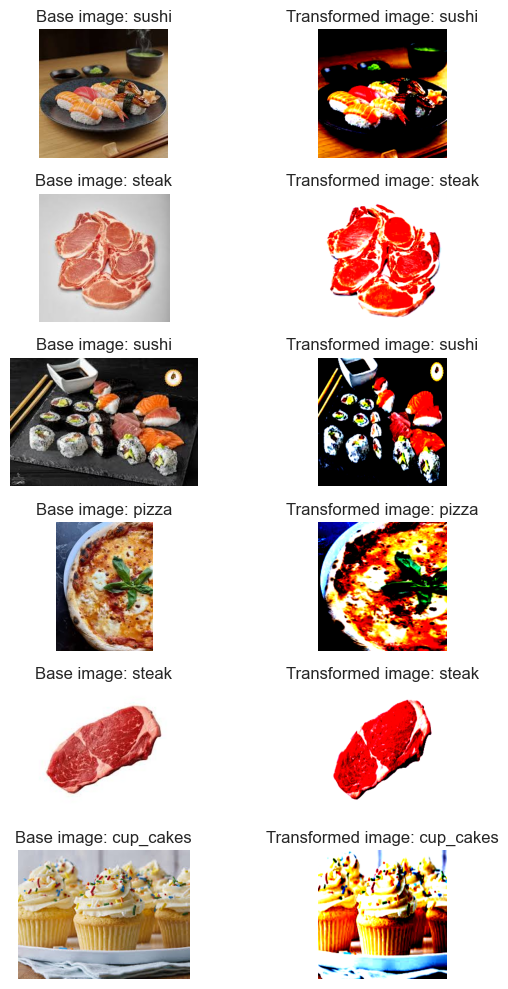

In [22]:
utilities.plot_samples_transformed(
    path=DATASET_TEST_FOLDER,
    classes_names=vit_test_dataset.classes,
    transform=vit_transform
)

### 3.2 EffNetB2 transforms pipeline

In [23]:
#this is the recipe for the ViT transformers since it achieved the best performance in terms of accuracy so far
EffNetB2_RESIZE = (288, 288)

effnetb2_transform = nn.Sequential(
    v2.ToImage(),
    v2.Resize(ViT_RESIZE),
    v2.CenterCrop(size=288),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
)

In [24]:
effnetb2_test_dataset = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=effnetb2_transform,
)

#the whole dataloader for the whole test set is needed because we want to compare the accuracy of both the models ==> a larger number of picture is needed
effnetb2_test_dataloader = DataLoader(
    dataset=effnetb2_test_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=BATCH_SIZE
)

#### as always let's visualize what we are importing to check if it is consistent with our expectactions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5354254].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


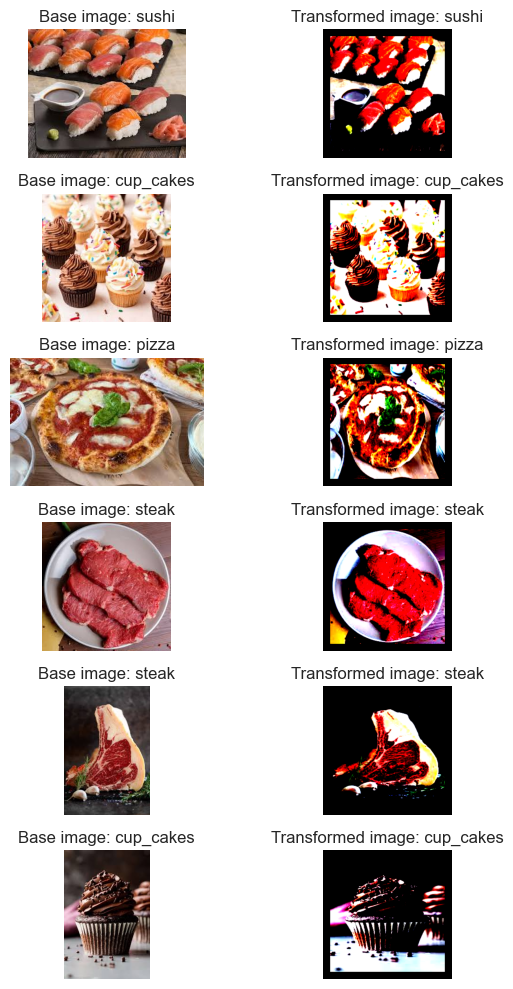

In [25]:
utilities.plot_samples_transformed(
    path=DATASET_TEST_FOLDER,
    classes_names=effnetb2_test_dataset.classes,
    transform=effnetb2_transform
)

## 4. Testing the models

In [26]:
device = 'cpu' #to simulate the performance on a normal cpu where most likely the model will run after the deployment
vit_model_pretrained.to(device)
effnet_b2_pretrained.to(device)

EffNetB2(
  (architecture): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          

In [27]:
loss_function = nn.CrossEntropyLoss()

### 4.1 EffNetB2 Model evaluation

In [28]:
effnet_b2_pretrained.to(device)

EffNetB2(
  (architecture): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          

In [29]:
effnet_b2_pretrained.eval()
with torch.no_grad():
    accuracy = []
    prediction = None
    targets = None
    inference_time = []
    for pics_batch, target_batch in vit_test_dataloader:
        pics_batch, target_batch = pics_batch.to(device), target_batch.to(device)
        
        inference_time_start = time()
        batch_test_loss, batch_test_acc, batch_pred = effnet_b2_pretrained.eval_step(
            batch_test_X=pics_batch,
            batch_test_y=target_batch,
            loss_foo=loss_function,
            device=device,
            return_pred=True
        )
        inference_time_end = time()
        
        inference_time.append(inference_time_end - inference_time_start)
        accuracy.append(batch_test_acc)
        if prediction is None:
            prediction = batch_pred.unsqueeze(1)
            targets = target_batch.unsqueeze(1)
        else:
            prediction = torch.vstack((prediction, batch_pred.unsqueeze(1)))
            targets = torch.vstack((targets, target_batch.unsqueeze(1)))
    
    avg_inference_time = sum(inference_time) / len(inference_time) / BATCH_SIZE
    accuracy = np.mean(accuracy)
    prediction = prediction.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    print(f'{effnet_b2_pretrained.name} | The accuracy of the model on a brand new set of samples is: {accuracy:.3%}')
    print(f'The average inference time per itmem is {avg_inference_time:.3f}')

EfficientNetB2 | The accuracy of the model on a brand new set of samples is: 86.607%
The average inference time per itmem is 0.087


In [30]:
sum_params = 0 #initializing a number to hold the overall number of params in the model and finally make a comparison

for param in effnet_b2_pretrained.parameters():
    sum_params += param.numel()
sum_params = sum_params / 1e6 #getting the millions of params

effnet_b2_resume = {
    'accuracy': accuracy,
    'inference_time_per_item': avg_inference_time,
    'millions_of_params': sum_params,
}

effnet_b2_resume

{'accuracy': np.float64(0.8660714285714286),
 'inference_time_per_item': 0.08666941523551941,
 'millions_of_params': 9.117039}

Text(0.5, 1.0, 'Confusion Matrix')

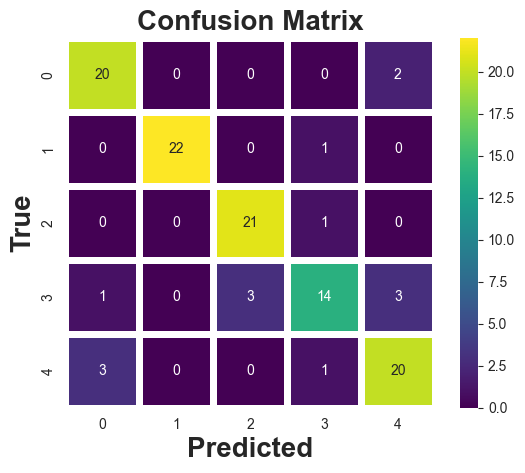

In [31]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
heatmap(
    confusion_matrix(targets, prediction),
    square=True,
    cmap='viridis',
    annot=True,
    linewidths=5,
    linecolor='white',
)
plt.xlabel('Predicted', fontsize=20, fontweight='bold')
plt.ylabel('True', fontsize=20, fontweight='bold')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')

### 4.2 ViT Model evaluation

In [32]:
vit_model_pretrained.to(device)

ViT_B_16(
  (pre_trained_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (l

In [33]:
vit_model_pretrained.eval()
with torch.no_grad():
    accuracy = []
    prediction = None
    targets = None
    inference_time = []
    for pics_batch, target_batch in vit_test_dataloader:
        pics_batch, target_batch = pics_batch.to(device), target_batch.to(device)
        
        inference_time_start = time()
        batch_test_loss, batch_test_acc, batch_pred = vit_model_pretrained.eval_step(
            batch_test_X=pics_batch,
            batch_test_y=target_batch,
            loss_foo=loss_function,
            device=device,
            return_pred=True
        )
        inference_time_end = time()
        
        inference_time.append(inference_time_end - inference_time_start)
        accuracy.append(batch_test_acc)
        if prediction is None:
            prediction = batch_pred.unsqueeze(1)
            targets = target_batch.unsqueeze(1)
        else:
            prediction = torch.vstack((prediction, batch_pred.unsqueeze(1)))
            targets = torch.vstack((targets, target_batch.unsqueeze(1)))
    
    avg_inference_time = sum(inference_time) / len(inference_time) / BATCH_SIZE
    accuracy = np.mean(accuracy)
    prediction = prediction.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    print(f'{vit_model_pretrained.name} | The accuracy of the model on a brand new set of samples is: {accuracy:.3%}')
    print(f'The average inference time per item is {avg_inference_time:.3f}')

ViT_model_pretrained | The accuracy of the model on a brand new set of samples is: 95.536%
The average inference time per item is 0.046


In [34]:
sum_params = 0 #initializing a number to hold the overall number of params in the model and finally make a comparison

for param in vit_model_pretrained.parameters():
    sum_params += param.numel()
sum_params = sum_params / 1e6 #getting the millions of params

vit_resume = {
    'accuracy': accuracy,
    'inference_time_per_item': avg_inference_time,
    'millions_of_params': sum_params,
}

vit_resume

{'accuracy': np.float64(0.9553571428571429),
 'inference_time_per_item': 0.04586737070764814,
 'millions_of_params': 85.802501}

Text(0.5, 1.0, 'Confusion Matrix')

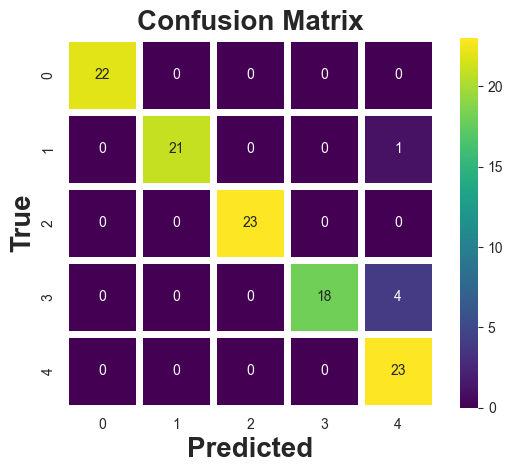

In [35]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
heatmap(
    confusion_matrix(targets, prediction),
    square=True,
    cmap='viridis',
    annot=True,
    linewidths=5,
    linecolor='white',
)
plt.xlabel('Predicted', fontsize=20, fontweight='bold')
plt.ylabel('True', fontsize=20, fontweight='bold')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')

#### Comparing the performance of the models we have:
* #### on one side the ViT model with its 85mio parameters, 0.013s prediction time and an accuracy of roughly 95%
* #### on the other hand the EffNetB2 model has only 9mio parameters, 0.005s to predict the class of a picture and accuracy of 88%
#### While the accuracy seems to push us using the ViT model, we have still no accurate info. In fact, the time we measured is only about the prediction time, and it's not enough. 
#### When deployed, the model will receive a picture or a video stream and our goal is to classify the picture in a quasi-live manner. We aim to have a prediction time shorter than 0,041s (24fps) for the whole pipeline. Therefore we need to use a different prediction function, which pre-processes the picture and then send it over for the prediction and finally returns the class for the same picture. 

### 4.3 Building up a Dataset for the prediction

In [36]:
final_test_dataset = ImageFolder(
    root='./Datasets/final_test',
)

In [37]:
NR_PICS = 75
random_pics = np.random.randint(low=0, high=len(final_test_dataset), size=(NR_PICS,)) #these are the indexes used to pick NR_PICS different pictures and pass them through the model to test it

### 4.4 Testing ViT Model - Single picture inference

In [38]:
#setting the properties inherited from the BluePrint object: self.model_transform and self.classes_map
vit_model_pretrained.model_transform = vit_transform
vit_model_pretrained.classes_map = final_test_dataset.class_to_idx

vit_model_pretrained.model_transform, vit_model_pretrained.classes_map

(Sequential(
   (0): ToImage()
   (1): Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
   (2): CenterCrop(size=(224, 224))
   (3): ToDtype(scale=True)
   (4): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 {'cup_cakes': 0, 'french_fries': 1, 'pizza': 2, 'steak': 3, 'sushi': 4})

In [39]:
final_resume_vit = []
for idx in random_pics:
    #the next foo returns a dict containg the main metrics to evaluate a model
    pred_dict = vit_model_pretrained.predict_single(
        input=final_test_dataset[idx][0],
        test_mode=True, 
        target_value=final_test_dataset[idx][1]
    )
    final_resume_vit.append(pred_dict) #appending what's been returned here above, to build a list of dict

from pandas import DataFrame

final_resume_vit = DataFrame(final_resume_vit)
final_resume_vit['Correct_Pred'] = final_resume_vit['Predicted_class'] - final_resume_vit['Expected_Class']
final_resume_vit['Correct_Pred'] = (final_resume_vit['Correct_Pred'] == 0).astype(bool)

In [40]:
pred_dict

{'Predicted_class': 0,
 'Prediction_proba': {'cup_cakes': 0.9998887777328491,
  'french_fries': 8.234493179770652e-06,
  'pizza': 2.6139534384128638e-05,
  'steak': 3.1612537441105815e-06,
  'sushi': 7.364543853327632e-05},
 'Prediction_time': 0.05727720260620117,
 'Expected_Class': 0}

In [41]:
final_resume_vit

,Predicted_class,Prediction_proba,Prediction_time,Expected_Class,Correct_Pred
0,2,"{'cup_cakes': 5.083219730295241e-05, 'french_f...",0.070106,2,True
1,0,"{'cup_cakes': 0.9977340698242188, 'french_frie...",0.055771,0,True
2,2,"{'cup_cakes': 0.0001236293464899063, 'french_f...",0.060286,2,True
3,0,"{'cup_cakes': 0.9998887777328491, 'french_frie...",0.054637,0,True
4,1,"{'cup_cakes': 0.0003422979498282075, 'french_f...",0.054405,1,True
...,...,...,...,...,...
70,4,"{'cup_cakes': 0.002695418195798993, 'french_fr...",0.054712,4,True
71,2,"{'cup_cakes': 7.436773739755154e-05, 'french_f...",0.060835,2,True
72,2,"{'cup_cakes': 0.00023275238345377147, 'french_...",0.054849,2,True
73,1,"{'cup_cakes': 0.00033075816463679075, 'french_...",0.064283,1,True


In [42]:
average_inference_time_vit = final_resume_vit['Prediction_time'].mean()
print(f'The average inference time per item is {average_inference_time_vit:.3f}s')

The average inference time per item is 0.059s


### 4.5 Testing EffNetB2 Model - Single picture inference

In [43]:
#setting the properties inherited from the BluePrint object: self.model_transform and self.classes_map
effnet_b2_pretrained.model_transform = vit_transform
effnet_b2_pretrained.classes_map = final_test_dataset.class_to_idx

effnet_b2_pretrained.model_transform, effnet_b2_pretrained.classes_map

(Sequential(
   (0): ToImage()
   (1): Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
   (2): CenterCrop(size=(224, 224))
   (3): ToDtype(scale=True)
   (4): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 {'cup_cakes': 0, 'french_fries': 1, 'pizza': 2, 'steak': 3, 'sushi': 4})

In [44]:
final_resume_effnet = []
for idx in random_pics:
    #the next foo returns a dict containing the main metrics to evaluate a model
    pred_dict = effnet_b2_pretrained.predict_single(
        input=final_test_dataset[idx][0],
        test_mode=True,
        target_value=final_test_dataset[idx][1]
    )
    final_resume_effnet.append(pred_dict) #appending what's been returned here above, to build a list of dict

from pandas import DataFrame

final_resume_effnet = DataFrame(final_resume_effnet)
final_resume_effnet['Correct_Pred'] = final_resume_effnet['Predicted_class'] - final_resume_effnet['Expected_Class']
final_resume_effnet['Correct_Pred'] = (final_resume_effnet['Correct_Pred'] == 0).astype(bool)

final_resume_effnet

,Predicted_class,Prediction_proba,Prediction_time,Expected_Class,Correct_Pred
0,2,"{'cup_cakes': 0.0006665171822533011, 'french_f...",0.080644,2,True
1,0,"{'cup_cakes': 0.8070677518844604, 'french_frie...",0.080500,0,True
2,2,"{'cup_cakes': 3.1552194190709315e-10, 'french_...",0.083467,2,True
3,4,"{'cup_cakes': 0.4456509053707123, 'french_frie...",0.069560,0,False
4,1,"{'cup_cakes': 3.289976666565053e-05, 'french_f...",0.132547,1,True
...,...,...,...,...,...
70,0,"{'cup_cakes': 0.9905203580856323, 'french_frie...",0.037089,4,False
71,2,"{'cup_cakes': 0.00011487556184874848, 'french_...",0.035830,2,True
72,2,"{'cup_cakes': 1.0981234481732827e-05, 'french_...",0.037949,2,True
73,1,"{'cup_cakes': 7.397300942102447e-05, 'french_f...",0.037333,1,True


In [45]:
average_inference_time_effnet = final_resume_effnet['Prediction_time'].mean()
print(f'The average inference time per item is {average_inference_time_effnet:.3f}s')

The average inference time per item is 0.043s


In [46]:
effnet_b2_resume['single_image_inference_time'] = np.round(average_inference_time_effnet, 3)
vit_resume['single_image_inference_time'] = np.round(average_inference_time_vit, 3)
effnet_b2_resume, vit_resume

({'accuracy': np.float64(0.8660714285714286),
  'inference_time_per_item': 0.08666941523551941,
  'millions_of_params': 9.117039,
  'single_image_inference_time': np.float64(0.043)},
 {'accuracy': np.float64(0.9553571428571429),
  'inference_time_per_item': 0.04586737070764814,
  'millions_of_params': 85.802501,
  'single_image_inference_time': np.float64(0.059)})

#### It seems a bit surprising that we are getting a better performance with the ViT time wise, but here an explanation: 
#### Computational structure:
* #### ViT is mainly built on matrices and linear multiplications (dense matrices), which run very efficiently on GPUs.
* #### EfficientNet uses many deep convolutions, depthwise separable convolutions, swish activations (computationally expensive), residual connections, and downsampling — all operations that are more complex to handle, especially on GPUs with batch size 1 (inference).
* #### Transformers scale well, whereas CNNs optimized for parameter efficiency can introduce computational bottlenecks **during inference when the inference is done on a batchsize = 1.**

In [47]:
final_resume_overall = DataFrame(
    data=[effnet_b2_resume, vit_resume],
    index=['EffNet_B2', 'VisualTransformer']
)
final_resume_overall

,accuracy,inference_time_per_item,millions_of_params,single_image_inference_time
EffNet_B2,0.866071,0.086669,9.117039,0.043
VisualTransformer,0.955357,0.045867,85.802501,0.059


(0.75, 1.0)

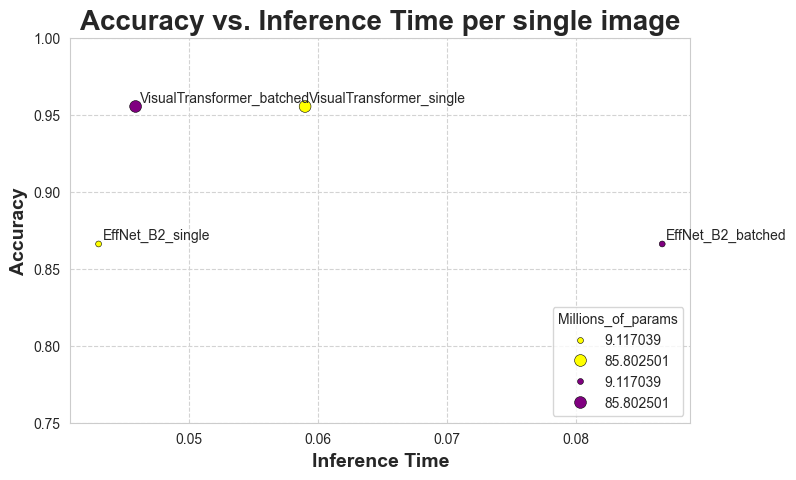

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=final_resume_overall,
    x='single_image_inference_time',
    y='accuracy',
    color='yellow',
    edgecolor='black',
    size='millions_of_params',
)
for index, row in final_resume_overall.iterrows():
    plt.annotate(text=f'{index}_single',
                 xy=(row['single_image_inference_time'] + 0.0003, row['accuracy'] + 0.003))
sns.scatterplot(
    data=final_resume_overall,
    x='inference_time_per_item',
    y='accuracy',
    color='purple',
    edgecolor='black',
    size='millions_of_params',
)
for index, row in final_resume_overall.iterrows():
    plt.annotate(text=f'{index}_batched',
                 xy=(row['inference_time_per_item'] + 0.0003, row['accuracy'] + 0.003))
plt.title('Accuracy vs. Inference Time per single image', fontsize=20, fontweight='bold')
plt.xlabel('Inference Time', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', title='Millions_of_params')
plt.grid(True, color='lightgray', linestyle='--')
#plt.xlim([0.004, 0.020])
plt.ylim([0.75, 1])

## 5. Deploying the model

#### Here is a snippet of the Gradio documentation (the whole documentation is <a href='https://www.gradio.app/guides/quickstart'>here</a>)
> **Understanding the Interface Class**<br>
> You'll notice that in order to make your first demo, you created an instance of the gr.Interface class. 
> The Interface class is designed to create demos for machine learning models which accept one or more inputs, and return one or more outputs. 
> The Interface class has three core arguments:
> * fn: the function to wrap a user interface (UI) around
> * <font color='orange'>*inputs: the Gradio component(s) to use for the input. The number of components should match the number of arguments in your function.*</font>
> * outputs: the Gradio component(s) to use for the output. The number of components should match the number of return values from your function.

In [49]:
import gradio as gr

vit_model_pretrained.model_transform = vit_transform
vit_model_pretrained.classes_map = final_test_dataset.class_to_idx

def unpacking_output(foo, input) -> list:
    output = list(foo(input).values())
    return output[0], output[1], output[2] #manually unpacking the output
    
    
demo = gr.Interface(
    fn=lambda x: unpacking_output(vit_model_pretrained.predict_single, x),
    #fn=vit_model_pretrained.predict_single,
    inputs=[gr.Image(type='pil')],
    outputs=[gr.Number(label='Predicted_Class'), 
             gr.Label(num_top_classes=5, label='Prediction Probabilities'),
             gr.Number(label='Prediction Time')])


In [50]:
demo.launch(show_error=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
